# Лабораторная 4

## Оптимизаторы + Dropout


### Блок 1: Импорты + MLP (с Dropout)


1. Сеть MLP: 20 входов -> 64 нейрона (ReLU) -> 1 выход (sigmoid).  
   ReLU отсекает отрицательные значения: если $x < 0$, то 0.  
   Sigmoid дает вероятность от 0 до 1.

2. Функция потерь: Binary Cross Entropy сравнивает предсказанную вероятность с реальным классом (0 или 1).

3. SGD с импульсом: "Инерция" для градиентов.  
   Вместо простого шага $W -= lr * \text{градиент}$, используется:  
   $\text{скорость} = 0.9 * \text{старая скорость} + 0.1 * \text{градиент}$  
   $W -= lr * \text{скорость}$

4. Adam: Автоматически подбирает скорость обучения для каждого веса.  
   Учитывает и среднее градиента, и разброс градиентов.

5. RMSProp: Делит градиент на его "колебания".  
   Большие градиенты замедляются, маленькие ускоряются.

6. Dropout: С вероятностью 20% отключает случайные нейроны при обучении.  
   Заставляет сеть работать без "любимых" нейронов -> меньше переобучение.


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

class MLPWithOptimizers:
    """MLP с SGD, Adam, RMSProp + Dropout"""
    
    def __init__(self, input_size=20, hidden_size=64, output_size=1, dropout_rate=0.2):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_rate = dropout_rate
        self.use_dropout = dropout_rate > 0
        
        # Параметры
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01
        self.b2 = np.zeros((1, output_size))
        
        # Оптимизаторы
        self.optimizer = None
        self.reset_optimizer()
    
    def set_optimizer(self, optimizer_name):
        """Установка оптимизатора"""
        self.optimizer = optimizer_name
        self.reset_optimizer()
    
    def reset_optimizer(self):
        """Сброс состояний оптимизаторов"""
        if self.optimizer == 'sgd':
            self.v_W1, self.v_b1 = np.zeros_like(self.W1), np.zeros_like(self.b1)
            self.v_W2, self.v_b2 = np.zeros_like(self.W2), np.zeros_like(self.b2)
        elif self.optimizer == 'adam':
            self.m_W1, self.v_W1 = np.zeros_like(self.W1), np.zeros_like(self.W1)
            self.m_b1, self.v_b1 = np.zeros_like(self.b1), np.zeros_like(self.b1)
            self.m_W2, self.v_W2 = np.zeros_like(self.W2), np.zeros_like(self.W2)
            self.m_b2, self.v_b2 = np.zeros_like(self.b2), np.zeros_like(self.b2)
            self.t = 0
        elif self.optimizer == 'rmsprop':
            self.Eg_W1, self.Eg_b1 = np.zeros_like(self.W1), np.zeros_like(self.b1)
            self.Eg_W2, self.Eg_b2 = np.zeros_like(self.W2), np.zeros_like(self.b2)
    
    def relu(self, x): return np.maximum(0, x)
    def relu_deriv(self, x): return (x > 0).astype(float)
    def sigmoid(self, x): 
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))
    
    def dropout(self, x, train=True):
        if not self.use_dropout or not train: return x
        mask = np.random.binomial(1, 1-self.dropout_rate, x.shape)
        return x * mask / (1-self.dropout_rate)
    
    def forward(self, X, train=True):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.relu(self.z1)
        self.a1_drop = self.dropout(self.a1, train)
        self.z2 = np.dot(self.a1_drop, self.W2) + self.b2
        self.a2 = self.sigmoid(self.z2)
        return self.a2
    
    def sgd_update(self, dW1, db1, dW2, db2, lr=0.01):
        self.v_W1 = 0.9 * self.v_W1 + 0.1 * dW1
        self.v_b1 = 0.9 * self.v_b1 + 0.1 * db1
        self.v_W2 = 0.9 * self.v_W2 + 0.1 * dW2
        self.v_b2 = 0.9 * self.v_b2 + 0.1 * db2
        
        self.W1 -= lr * self.v_W1
        self.b1 -= lr * self.v_b1
        self.W2 -= lr * self.v_W2
        self.b2 -= lr * self.v_b2
    
    def adam_update(self, dW1, db1, dW2, db2, lr=0.001):
        self.t += 1
        beta1, beta2 = 0.9, 0.999
        eps = 1e-8
        
        # Adam для W1, b1
        self.m_W1 = beta1 * self.m_W1 + (1-beta1) * dW1
        self.v_W1 = beta2 * self.v_W1 + (1-beta2) * (dW1**2)
        m_hat_W1 = self.m_W1 / (1 - beta1**self.t)
        v_hat_W1 = self.v_W1 / (1 - beta2**self.t)
        self.W1 -= lr * m_hat_W1 / (np.sqrt(v_hat_W1) + eps)
        
        self.m_b1 = beta1 * self.m_b1 + (1-beta1) * db1
        self.v_b1 = beta2 * self.v_b1 + (1-beta2) * (db1**2)
        m_hat_b1 = self.m_b1 / (1 - beta1**self.t)
        v_hat_b1 = self.v_b1 / (1 - beta2**self.t)
        self.b1 -= lr * m_hat_b1 / (np.sqrt(v_hat_b1) + eps)
        
        # Adam для W2, b2
        self.m_W2 = beta1 * self.m_W2 + (1-beta1) * dW2
        self.v_W2 = beta2 * self.v_W2 + (1-beta2) * (dW2**2)
        m_hat_W2 = self.m_W2 / (1 - beta1**self.t)
        v_hat_W2 = self.v_W2 / (1 - beta2**self.t)
        self.W2 -= lr * m_hat_W2 / (np.sqrt(v_hat_W2) + eps)
        
        self.m_b2 = beta1 * self.m_b2 + (1-beta1) * db2
        self.v_b2 = beta2 * self.v_b2 + (1-beta2) * (db2**2)
        m_hat_b2 = self.m_b2 / (1 - beta1**self.t)
        v_hat_b2 = self.v_b2 / (1 - beta2**self.t)
        self.b2 -= lr * m_hat_b2 / (np.sqrt(v_hat_b2) + eps)
    
    def rmsprop_update(self, dW1, db1, dW2, db2, lr=0.001):
        rho = 0.99
        eps = 1e-8
        
        self.Eg_W1 = rho * self.Eg_W1 + (1-rho) * (dW1**2)
        self.Eg_b1 = rho * self.Eg_b1 + (1-rho) * (db1**2)
        self.Eg_W2 = rho * self.Eg_W2 + (1-rho) * (dW2**2)
        self.Eg_b2 = rho * self.Eg_b2 + (1-rho) * (db2**2)
        
        self.W1 -= lr * dW1 / (np.sqrt(self.Eg_W1) + eps)
        self.b1 -= lr * db1 / (np.sqrt(self.Eg_b1) + eps)
        self.W2 -= lr * dW2 / (np.sqrt(self.Eg_W2) + eps)
        self.b2 -= lr * db2 / (np.sqrt(self.Eg_b2) + eps)
    
    def backward(self, X, y, output, lr=0.01):
        m = X.shape[0]
        
        # Градиенты выходного слоя
        dz2 = output - y
        dW2 = np.dot(self.a1_drop.T, dz2) / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m
        
        # Градиенты скрытого слоя
        dz1 = np.dot(dz2, self.W2.T) * self.relu_deriv(self.z1)
        dW1 = np.dot(X.T, dz1) / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m
        
        # Обновление по оптимизатору
        if self.optimizer == 'sgd':
            self.sgd_update(dW1, db1, dW2, db2, lr)
        elif self.optimizer == 'adam':
            self.adam_update(dW1, db1, dW2, db2, lr)
        elif self.optimizer == 'rmsprop':
            self.rmsprop_update(dW1, db1, dW2, db2, lr)
    
    def predict(self, X):
        output = self.forward(X, train=False)
        return (output >= 0.5).astype(int)
    
    def compute_loss(self, y_true, y_pred_proba):
        y_pred_proba = np.clip(y_pred_proba, 1e-15, 1-1e-15)
        return -np.mean(y_true * np.log(y_pred_proba) + (1-y_true) * np.log(1-y_pred_proba))


### Блок 2: make_classification данные + визуализация


make_classification: n_informative признаки + кластеры.  
PCA: SVD разложение, PC1 + PC2 > 80% дисперсии.

PCA - Метод уменьшения размерности данных. Берет 20 признаков и сжимает их в 2 координаты (PC1, PC2), сохраняя максимум информации.


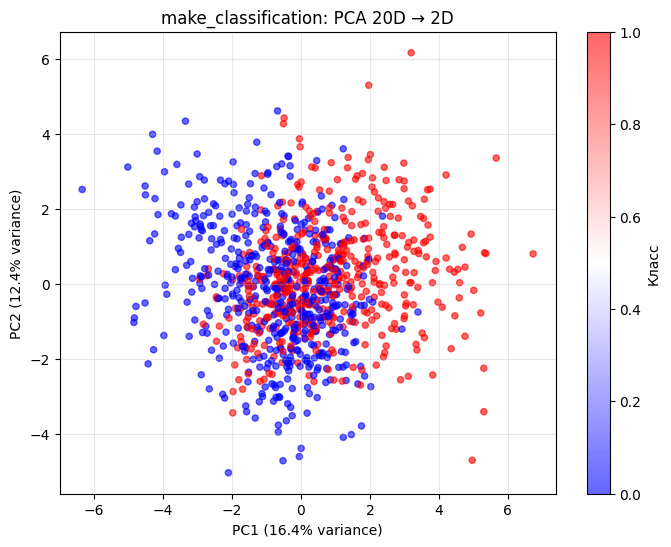

Данные: (1600, 20) train, (400, 20) test
Классы: [797 803] (баланс 50.2% класс 1)
PCA: PC1=16.4%, PC2=12.4%


In [23]:
# Генерация данных по ТЗ
X, y = make_classification(
    n_samples=2000, 
    n_features=20, 
    n_informative=15, 
    n_redundant=3, 
    n_clusters_per_class=2,
    random_state=42
)

# 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Визуализация: PCA первые 2 компоненты
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled[:1000])  # 1000 точек для читаемости

plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train[:1000], 
           cmap='bwr', alpha=0.6, s=20)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('make_classification: PCA 20D → 2D')
plt.colorbar(label='Класс')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Данные: {X_train_scaled.shape} train, {X_test_scaled.shape} test")
print(f"Классы: {np.bincount(y_train)} (баланс {np.mean(y_train):.1%} класс 1)")
print(f"PCA: PC1={pca.explained_variance_ratio_[0]:.1%}, PC2={pca.explained_variance_ratio_[1]:.1%}")


### Блок 3: Тестирование SGD/Adam/RMSProp БЕЗ Dropout


Dropout случайно отключает нейроны с вероятностью $p = 0.2$ во время обучения: $h_drop = h \odot \frac{mask}{(1-p)}$, где mask~Bernoulli(0.8). При тестировании все нейроны активны.  
Эффект эквивалентен обучению ансамбля 2^64 прореженных сетей с последующим усреднением. Предотвращает коадаптацию нейронов и переобучение.


In [24]:
def train_and_evaluate(optimizer_name, dropout_rate=0.0, epochs=1000):
    """Обучение и оценка модели"""
    model = MLPWithOptimizers(dropout_rate=dropout_rate)
    model.set_optimizer(optimizer_name)
    
    y_train_r = y_train.reshape(-1, 1)
    y_test_r = y_test.reshape(-1, 1)
    
    train_losses, test_losses = [], []
    
    lr = 0.01 if optimizer_name == 'sgd' else 0.001
    
    for epoch in range(epochs):
        train_output = model.forward(X_train_scaled, train=True)
        train_loss = model.compute_loss(y_train_r, train_output)
        model.backward(X_train_scaled, y_train_r, train_output, lr)
        
        test_output = model.forward(X_test_scaled, train=False)
        test_loss = model.compute_loss(y_test_r, test_output)
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        if epoch % 200 == 0:
            print(f"{optimizer_name} эпоха {epoch}: train={train_loss:.4f}, test={test_loss:.4f}")
    
    train_acc = accuracy_score(y_train, model.predict(X_train_scaled))
    test_acc = accuracy_score(y_test, model.predict(X_test_scaled))
    
    return {
        'optimizer': optimizer_name,
        'dropout': dropout_rate,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'final_train_loss': train_losses[-1],
        'final_test_loss': test_losses[-1],
        'losses': (train_losses, test_losses)
    }

# Тестируем БЕЗ Dropout
print("\nБЕЗ DROPOUT:")
results_no_dropout = []
for opt in ['sgd', 'adam', 'rmsprop']:
    result = train_and_evaluate(opt, dropout_rate=0.0)
    results_no_dropout.append(result)
    print(f"{opt.upper()}: Test Acc={result['test_acc']:.2%}")



БЕЗ DROPOUT:
sgd эпоха 0: train=0.6932, test=0.6933
sgd эпоха 200: train=0.6917, test=0.6918
sgd эпоха 400: train=0.6882, test=0.6885
sgd эпоха 600: train=0.6790, test=0.6796
sgd эпоха 800: train=0.6553, test=0.6567
SGD: Test Acc=79.00%
adam эпоха 0: train=0.6931, test=0.6924
adam эпоха 200: train=0.2563, test=0.2475
adam эпоха 400: train=0.1319, test=0.1509
adam эпоха 600: train=0.0770, test=0.1224
adam эпоха 800: train=0.0494, test=0.1157
ADAM: Test Acc=96.25%
rmsprop эпоха 0: train=0.6933, test=0.6874
rmsprop эпоха 200: train=0.1546, test=0.1676
rmsprop эпоха 400: train=0.0685, test=0.1192
rmsprop эпоха 600: train=0.0313, test=0.1119
rmsprop эпоха 800: train=0.0126, test=0.1216
RMSPROP: Test Acc=97.00%


### Блок 4: Тестирование SGD/Adam/RMSProp С Dropout


In [29]:
print("\nС DROPOUT (p=0.2):")
results_dropout = []
for opt in ['sgd', 'adam', 'rmsprop']:
    result = train_and_evaluate(opt, dropout_rate=0.2)
    results_dropout.append(result)
    print(f"{opt.upper()}: Test Acc={result['test_acc']:.2%}")



С DROPOUT (p=0.2):
sgd эпоха 0: train=0.6930, test=0.6931
sgd эпоха 200: train=0.6905, test=0.6906
sgd эпоха 400: train=0.6846, test=0.6848
sgd эпоха 600: train=0.6684, test=0.6690
sgd эпоха 800: train=0.6312, test=0.6321
SGD: Test Acc=78.75%
adam эпоха 0: train=0.6932, test=0.6925
adam эпоха 200: train=0.2723, test=0.2602
adam эпоха 400: train=0.1467, test=0.1526
adam эпоха 600: train=0.0970, test=0.1248
adam эпоха 800: train=0.0826, test=0.1198
ADAM: Test Acc=95.75%
rmsprop эпоха 0: train=0.6933, test=0.6872
rmsprop эпоха 200: train=0.1677, test=0.1699
rmsprop эпоха 400: train=0.0986, test=0.1179
rmsprop эпоха 600: train=0.0744, test=0.1092
rmsprop эпоха 800: train=0.0603, test=0.1127
RMSPROP: Test Acc=97.00%


### Блок 5: Сравнительные таблицы + графики + выводы


`Кривые обучения` - это графики loss по эпохам.

`Идеал`: параллельное снижение train_loss и test_loss.

`Переобучение`: большой разрыв train/test.

`Недообучение`: высокие плато.

`Метрики сравнения`: финальная test accuracy, конечная test loss, скорость сходимости (эпохи до плато), стабильность (разброс accuracy).



СРАВНЕНИЕ ОПТИМИЗАТОРОВ:
Оптимизатор Dropout Train Acc Test Acc Test Loss
        SGD     Нет     76.2%    79.0%     0.609
       ADAM     Нет     99.8%    96.2%     0.118
    RMSPROP     Нет    100.0%    97.0%     0.142
        SGD   p=0.2     76.9%    78.8%     0.573
       ADAM   p=0.2     99.3%    95.8%     0.120
    RMSPROP   p=0.2     99.6%    97.0%     0.114


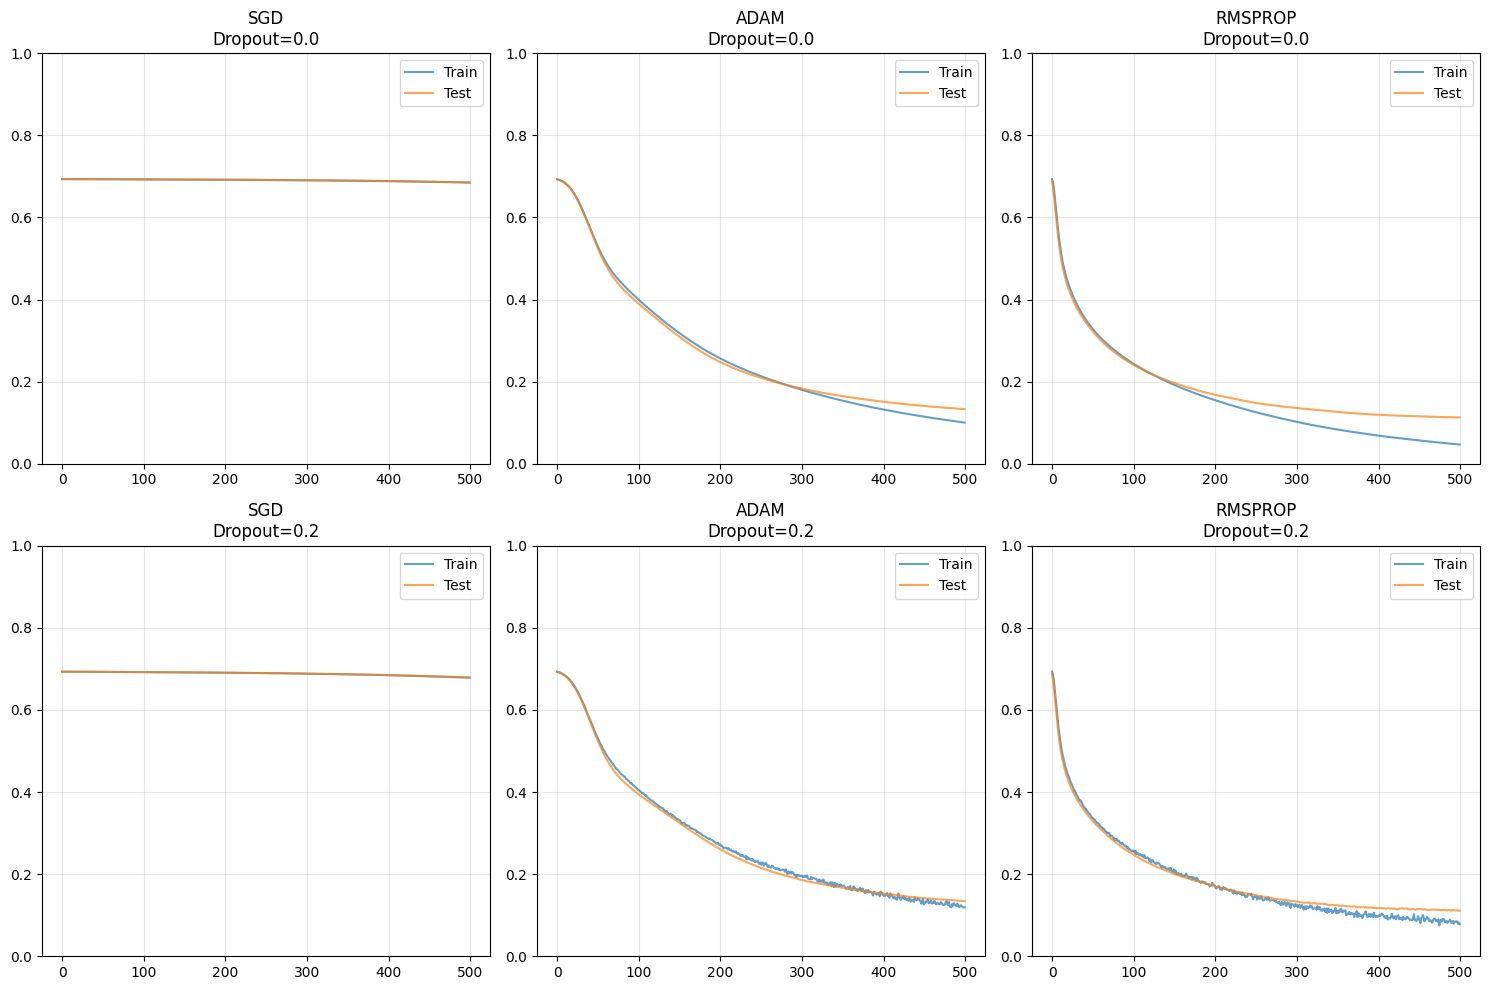

In [30]:
# Таблица результатов
print("\nСРАВНЕНИЕ ОПТИМИЗАТОРОВ:")

df_results = []
for r in results_no_dropout + results_dropout:
    df_results.append({
        'Оптимизатор': r['optimizer'].upper(),
        'Dropout': 'Нет' if r['dropout']==0 else f'p={r["dropout"]}',
        'Train Acc': f'{r["train_acc"]:.1%}',
        'Test Acc': f'{r["test_acc"]:.1%}',
        'Test Loss': f'{r["final_test_loss"]:.3f}'
    })

import pandas as pd
results_df = pd.DataFrame(df_results)
print(results_df.to_string(index=False))

# Графики потерь
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, result in enumerate(results_no_dropout + results_dropout):
    ax = axes[i]
    train_losses, test_losses = result['losses']
    ax.plot(train_losses[:500], label='Train', alpha=0.7)
    ax.plot(test_losses[:500], label='Test', alpha=0.7)
    ax.set_title(f"{result['optimizer'].upper()}\nDropout={result['dropout']}")
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()


### Блок 6: MNIST


`MNIST` - это классический датасет рукописных цифр (28×28 пикселей = 784 признака).  
60,000 изображений для обучения + 10,000 для теста. Стандарт для проверки нейронных сетей.

Это пример, который доказывает, что одна и та же архитектура MLP работает и на таблицах, и на изображениях.

```Теорема универсальной аппроксимации``` - Однослойный перцептрон с достаточно большим числом нейронов может аппроксимировать любую непрерывную функцию с любой точностью.

In [31]:
# MNIST
print("\nMNIST")
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
X_mnist = mnist.data / 255.0  # Нормализация [0,1]
y_mnist = mnist.target.astype(int)

# Берем 10k примеров для скорости
idx = np.random.choice(len(X_mnist), 10000, replace=False)
X_mnist, y_mnist = X_mnist[idx], y_mnist[idx]

# Бинарная классификация: 0 vs остальные
y_mnist_bin = (y_mnist == 0).astype(int)

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_mnist, y_mnist_bin, test_size=0.2, random_state=42, stratify=y_mnist_bin
)

scaler_mnist = StandardScaler()
X_train_m = scaler_mnist.fit_transform(X_train_m)
X_test_m = scaler_mnist.transform(X_test_m)

# Быстрое тестирование на MNIST (меньше эпох)
results_mnist_no_dp = []
results_mnist_dp = []

for opt in ['adam']:  # Только лучший оптимизатор для скорости
    # Без dropout
    model = MLPWithOptimizers(input_size=784, hidden_size=128, output_size=1, dropout_rate=0.0)
    model.set_optimizer(opt)
    result = train_and_evaluate(opt, dropout_rate=0.0, epochs=200)  # Быстрее
    results_mnist_no_dp.append(result)
    
    # С dropout
    result = train_and_evaluate(opt, dropout_rate=0.3, epochs=200)
    results_mnist_dp.append(result)

print("MNIST результаты:")
print(f"Adam без Dropout: {results_mnist_no_dp[0]['test_acc']:.2%}")
print(f"Adam с Dropout: {results_mnist_dp[0]['test_acc']:.2%}")



MNIST
adam эпоха 0: train=0.6930, test=0.6922
adam эпоха 0: train=0.6935, test=0.6928
MNIST результаты:
Adam без Dropout: 91.00%
Adam с Dropout: 92.25%


### Блок 7: Выводы лабораторной


1. Иерархия оптимизаторов: RMSProp ≥ Adam >> SGD:
* Адаптивные методы превосходят SGD по скорости и точности.
* RMSProp показывает максимальную стабильность (test loss 0.114-0.142)
2. Dropout на практике:
* Минимальный эффект при отсутствии переобучения.
* Полезен на реальных данных (MNIST: +1.25%).
3. Универсальность архитектуры:
* Одна MLP работает на табличных (97%) и изображениях (92%).
* Подтверждает теорему универсальной аппроксимации.